In [2]:
import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)
import networkx as nx

from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp


from jax import lax, jit
import jax.random as random
from jax.experimental import sparse


from os.path import isfile
import json



# load path_figures from config_user.json if it exists
path_config = "../config_user.json"
if isfile(path_config):
    with open(path_config, 'r') as f:
        config = json.load(f)
else:
    with open("../config_default.json", 'r') as f:
        config = json.load(f)

path_figures = config["path_figures"]
print(path_figures)




./figures/


In [3]:
savefig_args = {
    'transparent': True,
    'format': 'pdf',
    'dpi': 300,
    'facecolor': 'none',
    'bbox_inches': 'tight',
    'pad_inches': 0
}

#mm to inches conversion
def mm_to_inches(mm):
    return mm / 25.4

#colormap for raster plot
colors = [(0, 0, 0, 0),  
          (0, 0, 0.55, 1)]  
cmap = ListedColormap(colors)

In [4]:
#random network implementation
def random_graph(N, k, J, seed=100, weights='homogeneous', weight_generator=None):
    '''
    Creates a random, directed, and weighted Erdos Renyi graph.
    Parameters:
        N: number of nodes
        k: mean nodal degree
        J: weight parameters. If homogeneous weights: constant float, if gaussian weigts: J=(J_mean, J_sigma)
        seed: seed for the ER graph generation
        weights: Type of weights, 'homogeneous' or 'gaussian'
        generator: random generator for random weights
    Returns:
        sparse jax.experimental coupling matrix 
    '''
    p = k / (N - 1)
    
    # Create ER graph
    G = nx.erdos_renyi_graph(N, p, directed=True, seed=seed)
    
    # Put weights
    for u, v in G.edges():
        if weights=='homogeneous':
            G[u][v]['weight'] = J#generator.normal(J, J/5)
        elif weights=='gaussian':
            G[u][v]['weight'] = weight_generator.normal(J[0], J[1])
    
    # Get the adjacency matrix in sparse format
    adj_matrix = nx.adjacency_matrix(G, weight='weight')
    
    return sparse.BCSR.from_scipy_sparse(adj_matrix)

In [5]:


k=50
m=0.0005 # Mean J/k
N=1000
L= random_graph(N, k, J=m/k, weights='homogeneous')
@jit
def FHN_step(u, v, N, a, b, e,  sigma, L, key, delta_t):
    
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) + (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N=N, y0='zeros', a=3, b=0.2, e=1e-2,  J=L, sigma=0.1, delta_t=0.1, total_time=3000.0, key=random.PRNGKey(0)):
    if y0=='zeros':
        y0 = jnp.zeros(2*N)
    
    if type(y0) == str and y0=='random':
        y0 = random.normal(random.PRNGKey(0), shape=(2*N,))*e
     
    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)

    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    # Define the scan function
    def scan_fn(carry, step):
        u, v, key = carry
        key, subkey = random.split(key)
        u, v = FHN_step(u, v, N, a, b, e, sigma, L, subkey, delta_t)
        return (u, v, key), (u, v)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), None, length=num_steps)
    u_trajectory=u_trajectory[::10]
    v_trajectory=v_trajectory[::10]

    return u_trajectory, v_trajectory



C:\Users\pelli\AppData\Local\Temp\ipykernel_25756\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


In [6]:
#healthy brain simulation. Change sigma to get sparser spikes (lower limit to get spikes is around 0.045 /0.5)
m1 =0.005
L1= random_graph(N, k, J=m1/k, weights='homogeneous')
u_sol_health, v_sol_health = run_simulation(N=N, J=L1, a=3, b=0.2, e=0.01,  sigma=0.05, total_time=3000, key=random.PRNGKey(int(1000)))

u_sol_health=u_sol_health.T
u_sol_health_bin=jnp.where(u_sol_health>0.5, 1, 0)

C:\Users\pelli\AppData\Local\Temp\ipykernel_25756\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


In [6]:
## epileptic brain simulation

m2 =0.145
L2= random_graph(N, k, J=m2/k, weights='homogeneous')
u_sol_ep, v_sol_ep = run_simulation(N=N, J=L2, a=3, b=0.2, e=0.01,  sigma=0.1, total_time=3000, key=random.PRNGKey(int(1000)))

u_sol_ep=u_sol_ep.T
u_sol_ep_bin=jnp.where(u_sol_ep>0.5, 1, 0)

C:\Users\pelli\AppData\Local\Temp\ipykernel_24292\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


## Raster plot

In [7]:
# get rid of the transient and plot fewer neurons
# [N, T]
data_health =u_sol_health_bin[950:, 100:]



# Add blank rows between binary rows 
N1, T1 = data_health.shape
gap1 = 1  # Gap size (number of blank rows)
data_health_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data_health_with_blanks[i * (gap1 + 1), :] = data_health[i, :]




In [8]:
data_ep=u_sol_ep_bin[950:, 100:]
N2, T2 = data_ep.shape
gap2 = 1  # Gap size (number of blank rows)
data_ep_with_blanks = np.zeros((N2 * (gap2 + 1), T2))
for i in range(N2):
    data_ep_with_blanks[i * (gap2 + 1), :] = data_ep[i, :]



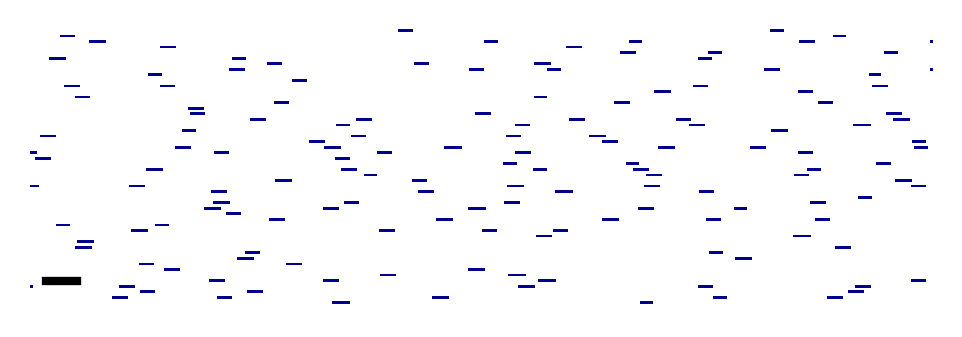

In [8]:
# Desired dimensions in mm
width_mm = 78
height_mm = 24


# Plot the data
plt.figure(figsize=(mm_to_inches(width_mm), mm_to_inches(height_mm)), facecolor='none', dpi=300)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
plt.imshow(data_health_with_blanks, cmap=cmap, interpolation='none',  aspect='auto', rasterized=True)
plt.xticks([])  
plt.yticks([]) 
#plt.ylabel("Excitable cells ", fontsize=16)
#plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Add a small black scalebar
scalebar_length = 100  # Length of the scalebar in data units
scalebar_height = 5  # Height of the scalebar in data units
scalebar_x = 50  # X position of the scalebar
scalebar_y = 90  # Y position of the scalebar

plt.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y], color='black', lw=2)
##plt.plot([scalebar_x, scalebar_x], [scalebar_y - scalebar_height / 2, scalebar_y + scalebar_height / 2], color='black', lw=2)
#plt.plot([scalebar_x + scalebar_length, scalebar_x + scalebar_length], [scalebar_y - scalebar_height / 2, scalebar_y + scalebar_height / 2], color='black', lw=2)

plt.savefig('FHN_erdos-renyi_toybrain_raster_m=0.005.pdf', **savefig_args)



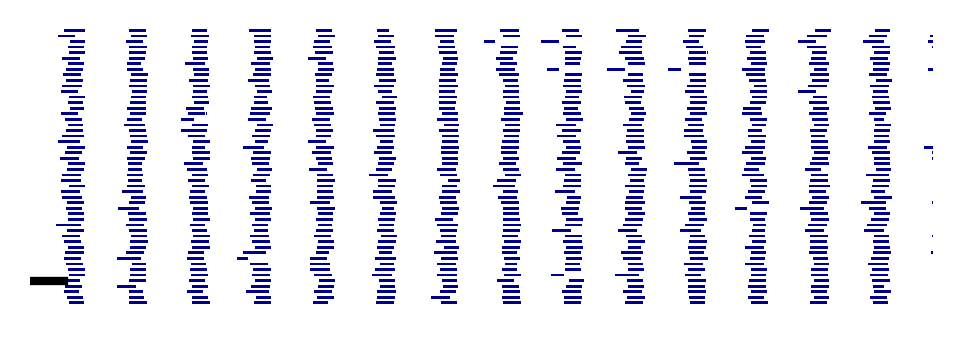

In [13]:
# Desired dimensions in mm
width_mm = 78
height_mm = 24


# Plot the data
plt.figure(figsize=(mm_to_inches(width_mm), mm_to_inches(height_mm)), facecolor='none', dpi=300)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
plt.imshow(data_ep_with_blanks, cmap=cmap, interpolation='none',  aspect='auto', rasterized=True)
plt.xticks([])  
plt.yticks([]) 
#plt.ylabel("Excitable cells ", fontsize=16)
#plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# Add a small black scalebar
scalebar_length = 100  # Length of the scalebar in data units
scalebar_height = 5  # Height of the scalebar in data units
scalebar_x = 10  # X position of the scalebar
scalebar_y = 90  # Y position of the scalebar

plt.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y], color='black', lw=2)


plt.savefig('FHN_erdos-renyi_toybrain_raster_m=0.145.pdf', **savefig_args)



## EEG

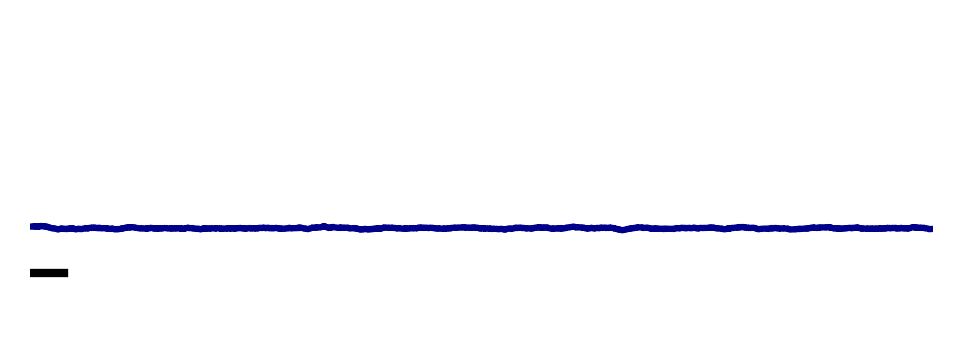

In [9]:
#here the y scale is set to match the one of the heart simulation
fig, ax = plt.subplots( figsize=(mm_to_inches(width_mm), mm_to_inches(height_mm)), facecolor='none', dpi=300)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
EEG=u_sol_health[ :, 100:].sum(axis=0)/10000
ax.plot(EEG, color='darkblue')

ax.set_ylim([-0.09,0.24])
ax.set_xlim(0, 2900)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Add a small black scalebar
scalebar_length = 100  # Length of the scalebar in data units
scalebar_height = 5  # Height of the scalebar in data units
scalebar_x = 10  # X position of the scalebar
scalebar_y = -0.05 # Y position of the scalebar

ax.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y], color='black', lw=2)
fig.savefig('FHN_erdos-renyi_toybrain_collective_stimulus_m=0.005.pdf', **savefig_args)

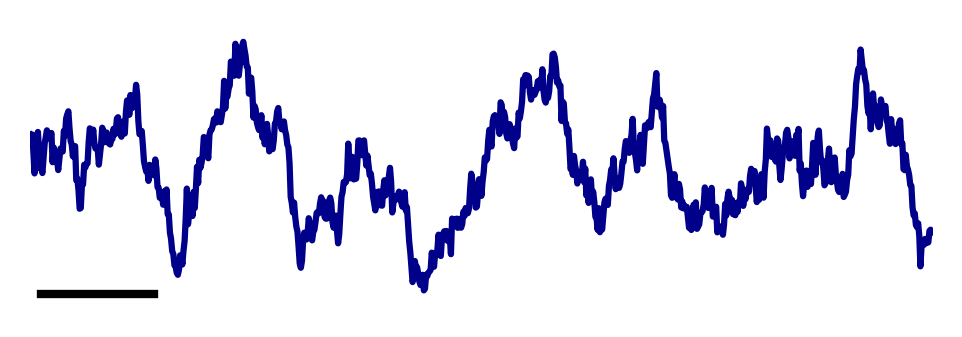

In [18]:
# inset EEG
fig, ax = plt.subplots( figsize=(mm_to_inches(width_mm), mm_to_inches(height_mm)), facecolor='none', dpi=300)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
EEG=u_sol_health[ :, 2200:].sum(axis=0)/10000
ax.plot(EEG, color='darkblue')


ax.set_xlim(0, 800)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
scalebar_length = 100  # Length of the scalebar in data units
scalebar_height = 5  # Height of the scalebar in data units
scalebar_x = 10  # X position of the scalebar
scalebar_y = 0.002 # Y position of the scalebar

ax.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y], color='black', lw=2)
fig.savefig('FHN_erdos-renyi_toybrain_collective_stimulus_inset.pdf', **savefig_args)

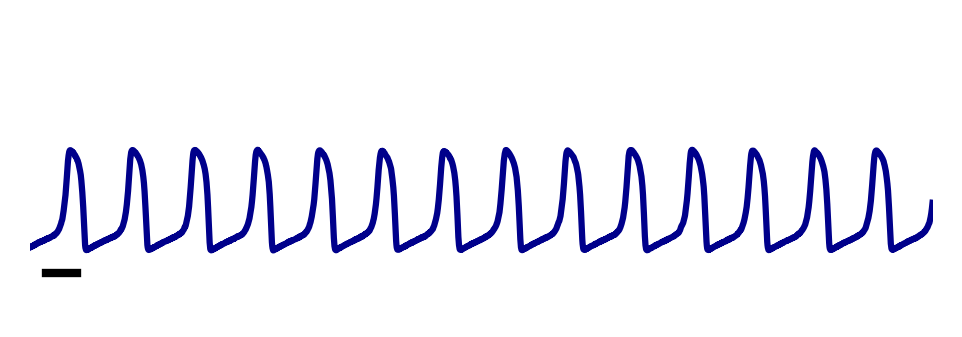

In [31]:
#here the y scale is set to match the one of the heart simulation
fig, ax = plt.subplots( figsize=(mm_to_inches(width_mm), mm_to_inches(height_mm)), facecolor='none', dpi=300)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
EEG=u_sol_ep[ :, 100:].sum(axis=0)/10000
ax.plot(EEG, color='darkblue')

ax.set_ylim([-0.09,0.24])
ax.set_xlim(0, 2900)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

scalebar_length = 100  # Length of the scalebar in data units
scalebar_height = 5  # Height of the scalebar in data units
scalebar_x = 50  # X position of the scalebar
scalebar_y = -0.05 # Y position of the scalebar (adjusted to be within visible range)

ax.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y], color='black', lw=2)
fig.savefig('FHN_erdos-renyi_toybrain_collective_stimulus_m=0.145.pdf', **savefig_args)

## Snapshots

In [12]:
def plot_graph_on_circle(
    y,
    J,
    ax,
    subset_size=10,
    format_axes=False,
    plot_connections=True,
    arrows=True,
    marker_size=200,
    idle_color="white",
    spiking_color="royalblue",
    weighted_connections_cmap=None,
    weighted_connections_norm=None,
):
    """
    Plot the graph on a circle with nodes colored based on their V value.
    Parameters:
        J (scipy.sparse matrix): adjacency matrix
        y (numpy.ndarray): (N) states of the neurons
        subset_size: number of nodes to plot, if 'all' then subset_size=N
    """
    J_dense = J.todense()
    #else:
   
    N = len(y)

    # Select a subset of nodes to plot
    if type(subset_size) == str and subset_size == "all":
        subset_size = N
    subset_indices = np.random.choice(N, subset_size, replace=False)

    # Create positions for the nodes on a circle
    theta = np.linspace(0, 2 * np.pi, subset_size, endpoint=False)
    positions = np.column_stack((np.cos(theta), np.sin(theta)))

    if format_axes:
        ax.clear()
        ax.set_aspect("equal")
        ax.axis("off")

    # Plot the connections of the subset
    if plot_connections:
        i_indices, j_indices = np.meshgrid(
            subset_indices, subset_indices, indexing="ij"
        )
        mask = J_dense[i_indices, j_indices] != 0
        i_indices, j_indices = i_indices[mask], j_indices[mask]

        for i, j in zip(i_indices, j_indices):
            if type(weighted_connections_cmap) == type(None):
                color = "black"
            else:
                color = weighted_connections_cmap(
                    weighted_connections_norm(J_dense[i, j])
                )
            if arrows:
                ax.arrow(
                    x=positions[i % subset_size, 0],
                    y=positions[i % subset_size, 1],
                    dx=positions[j % subset_size, 0] - positions[i % subset_size, 0],
                    dy=positions[j % subset_size, 1] - positions[i % subset_size, 1],
                    color=color,
                    alpha=1,
                    head_width=0.02,
                    length_includes_head=True,
                )
            else:
                ax.plot(
                    [positions[i % subset_size, 0], positions[j % subset_size, 0]],
                    [positions[i % subset_size, 1], positions[j % subset_size, 1]],
                    "-",
                    color=color,
                    alpha=0.1,
                )
    # Add a colorbar with specific ticks
    subset_y = y[subset_indices]
    
    norm = plt.Normalize(vmin=-np.max(np.abs(subset_y)), vmax=np.max(np.abs(subset_y)))
    cmap = plt.get_cmap("seismic")
    ##sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm.set_array([])
    ##cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.8)
    #cbar.set_label('V', rotation=0, labelpad=15, fontsize=16, color='black')
    #cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
    #cbar.ax.tick_params(labelsize=14)
    colors = cmap(norm(subset_y))
    ax.scatter(
        positions[:, 0], positions[:, 1], c=colors, edgecolors="black", s=marker_size
    )

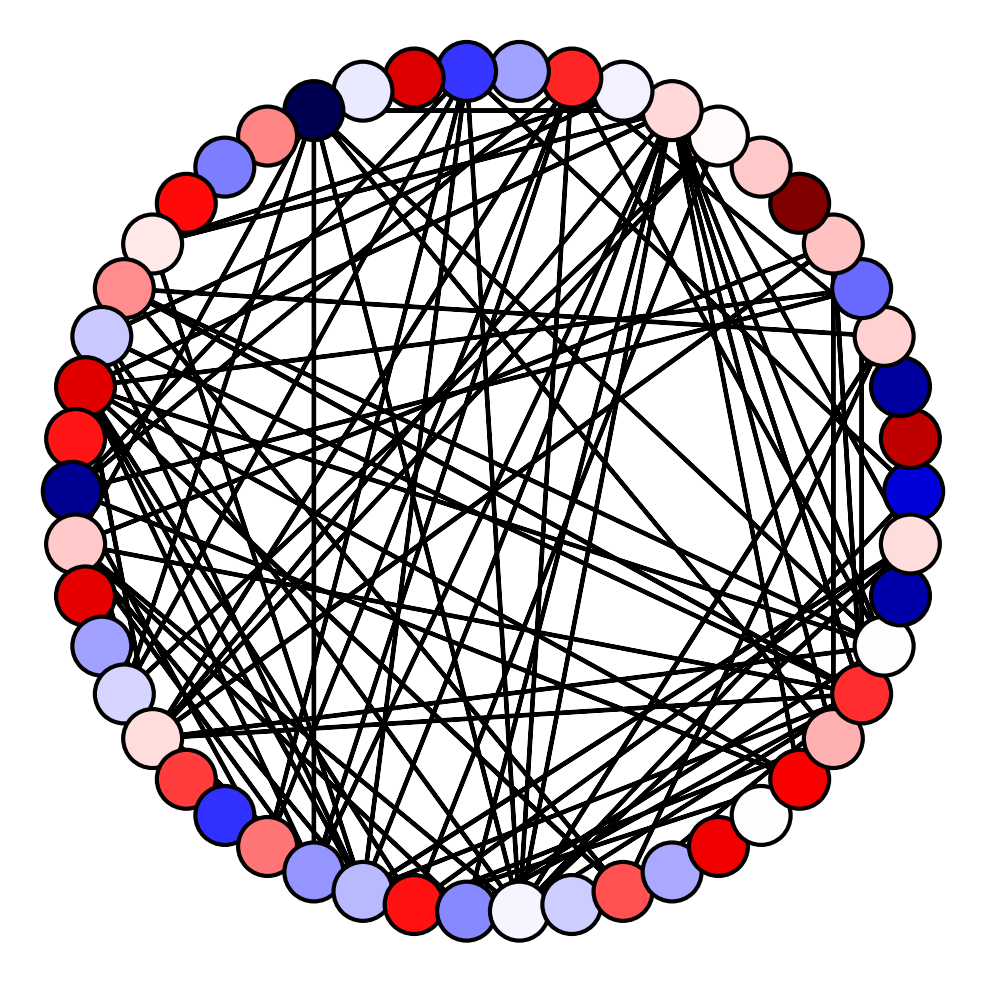

In [43]:
width_mm=80
height_mm=80
fig, ax = plt.subplots( figsize=(mm_to_inches(width_mm), mm_to_inches(height_mm)), facecolor='none', dpi=300)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
plot_graph_on_circle(u_sol_health[:, 0], L1, plt.gca(), subset_size=50, format_axes=True, plot_connections=True, arrows=True, marker_size=200, weighted_connections_cmap=None, weighted_connections_norm=None)
fig.savefig('FHN_erdos-renyi_toybrain_m=0.005_snapshot.pdf', **savefig_args)

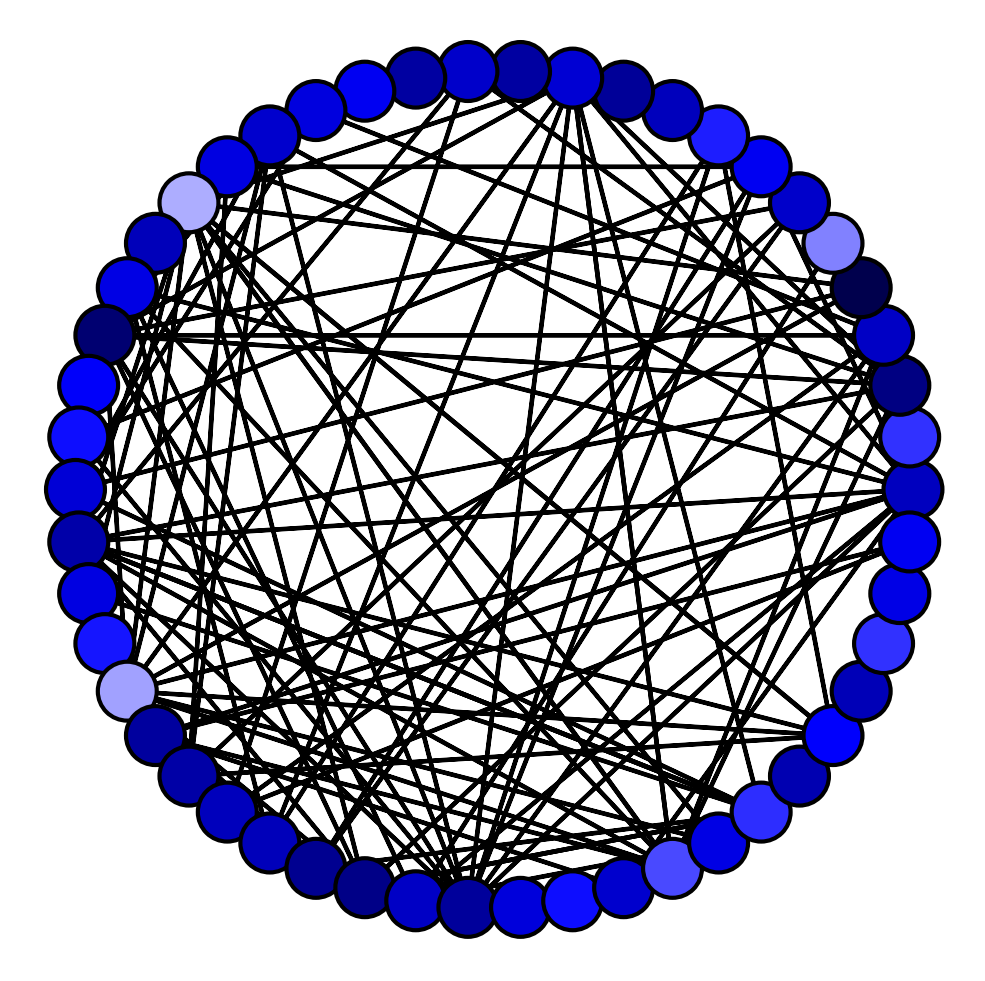

In [33]:
width_mm=80
height_mm=80
fig, ax = plt.subplots( figsize=(mm_to_inches(width_mm), mm_to_inches(height_mm)), facecolor='none', dpi=300)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
plot_graph_on_circle(u_sol_ep[:,1500 ], L2, plt.gca(), subset_size=50, format_axes=True, plot_connections=True, arrows=True, marker_size=200, weighted_connections_cmap=None, weighted_connections_norm=None)
fig.savefig('FHN_erdos-renyi_toybrain_m=0.145_snapshot.pdf', **savefig_args)

In [27]:
u_sol_ep=jnp.array(u_sol_ep)
print(u_sol_ep.shape)

(1000, 3000)
